In [1]:
import pandas as pd
import numpy as np
from pyDOE import lhs
import tqdm
import shap
import torch
import gpytorch
import botorch
import seaborn as sns
import matplotlib.pyplot as plt

from botorch.models import ModelListGP

torch.manual_seed(42)
np.random.seed(0)

In [2]:
def prepare_and_scale_data(df, optimization_space, target_tc=300.0, sigma=35.0):
    df_new = df.copy()
    
    # Gaussian reward centered on target
    df_new['Targeted Tc'] = torch.exp(- ((torch.tensor(df_new['Tc (K)'].values) - target_tc) ** 2) / (2 * sigma**2))
    
    descriptor_cols = ['Fe stoichiometry (x)',
                       'Substitution Si (x)',
                       'Al/Ge ratio',
                       'Annealing temperature (K)']
    
    X = torch.tensor(df_new[descriptor_cols].values, dtype=torch.double)
    Y = torch.tensor(df_new[['Targeted Tc', 'Delta S (J kg-1 K-1)']].values, dtype=torch.double)
    
    min_vals = torch.tensor([x[0] for x in optimization_space], dtype=torch.double).unsqueeze(0)
    max_vals = torch.tensor([x[1] for x in optimization_space], dtype=torch.double).unsqueeze(0)
    X_scaled = (X - min_vals) / (max_vals - min_vals)

    Y_mean = Y.mean(dim=0, keepdim=True)
    Y_std = Y.std(dim=0, keepdim=True)
    Y_scaled = (Y - Y_mean) / Y_std

    return df_new, X_scaled, Y_scaled, (min_vals, max_vals), (Y_mean, Y_std)

In [3]:
def describe_candidate(X_candidate_real, descriptors):
    
    values = X_candidate_real.view(-1).tolist() 

    description = "\nSuggested next experimental conditions:\n\n"
    for name, val in zip(descriptors, values):
        unit = ""
        if "temperature" in name.lower():
            unit = " K"
        elif "ratio" in name.lower():
            unit = ""
        elif "%" in name:
            unit = " mol. %"
        description += f"  - {name}: {val:.3f}{unit}\n"
    
    return description

In [4]:
class ARDGPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        ard_dims = train_x.shape[-1]
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
def train_gp_models(train_x, train_y, noise=1e-4, lr=0.01, n_iter=2000):

    models = []
    likelihoods = []

    for i in range(train_y.shape[-1]):
        y_i = train_y[..., i].contiguous()
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = ARDGPModel(train_x, y_i, likelihood)
        model.likelihood.noise = noise

        model.train()
        likelihood.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for _ in range(n_iter):
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, y_i)
            if loss.dim() != 0:
                raise RuntimeError(f"Loss must be scalar, got shape {loss.shape}")
            loss.backward()
            optimizer.step()


        model.eval()
        likelihood.eval()
        models.append(model)
        likelihoods.append(likelihood)

    return ModelListGP(*models), likelihoods


In [6]:
maximized_value = ['Tc (K)', 'Delta S (J kg-1 K-1)']

descriptors = ['Fe stoichiometry (x)',
               'Substitution Si (x)',
               'Al/Ge ratio',
               'Annealing temperature (K)',
                ]

optimization_space = [(  0.25,  0.75), # Fe stoichiometry (x)
                      (  0.0,    0.5), # Substitution Si (x)
                      (  0.0,    1.0), # Al percentage,
                      (800.0, 1500.0), # Annealing temperature (K)
                     ]

num_dim = len(descriptors)

In [7]:
initial_data = [['D18',  320.0,  44.0,  0.5, 0.0525, 1.0, 1500.0],
                ['D19',  276.0,  32.0,  0.5,   0.06, 1.0, 1173.0],
                ['D20',  220.0,  31.0,  0.5, 0.0685, 1.0, 1173.0],
                ['B10',  252.0,  15.0, 0.55,   0.05, 1.0, 1073.0],
                ['B11',  275.0,  43.0, 0.52,   0.05, 1.0, 1073.0],
                ['B12',  305.0,  53.0,  0.5,   0.05, 1.0, 1073.0],
                ['B13',  327.0,  36.0, 0.48,   0.05, 1.0, 1073.0],
                ['B14',  373.0,  11.0, 0.45,   0.05, 1.0, 1073.0],
                [ 'F1',  176.0,  72.0, 0.47,   0.47, 0.0, 1073.0]
               ]

columns_name = ['Sample name'] + maximized_value + descriptors

In [8]:
df = pd.DataFrame(initial_data, columns=columns_name).set_index('Sample name')
df

,Tc (K),Delta S (J kg-1 K-1),Fe stoichiometry (x),Substitution Si (x),Al/Ge ratio,Annealing temperature (K)
Sample name,,,,,,
D18,320.0,44.0,0.50,0.0525,1.0,1500.0
D19,276.0,32.0,0.50,0.0600,1.0,1173.0
D20,220.0,31.0,0.50,0.0685,1.0,1173.0
B10,252.0,15.0,0.55,0.0500,1.0,1073.0
B11,275.0,43.0,0.52,0.0500,1.0,1073.0
B12,305.0,53.0,0.50,0.0500,1.0,1073.0
B13,327.0,36.0,0.48,0.0500,1.0,1073.0
B14,373.0,11.0,0.45,0.0500,1.0,1073.0
F1,176.0,72.0,0.47,0.4700,0.0,1073.0


In [9]:
df_prepared, X_scaled, Y_scaled, X_scaling, Y_scaling = prepare_and_scale_data(df, optimization_space)

In [10]:
model, likelihoods = train_gp_models(X_scaled, Y_scaled)

In [11]:
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from botorch.acquisition.multi_objective.logei import qLogExpectedHypervolumeImprovement
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.optim import optimize_acqf

def propose_candidate_qlogehvi(model, Y_scaled, X_scaling, bounds=None, num_samples=128):
    
    min_vals, max_vals = X_scaling
    d = min_vals.shape[-1]

    if bounds is None:
        bounds = torch.stack([torch.zeros(d, dtype=torch.double), torch.ones(d, dtype=torch.double)])

    ref_point = Y_scaled.min(dim=0).values - 0.1
    partitioning = FastNondominatedPartitioning(ref_point=ref_point, Y=Y_scaled)
    sampler = SobolQMCNormalSampler(sample_shape=torch.Size([num_samples]))

    acq_func = qLogExpectedHypervolumeImprovement(
        model=model,
        ref_point=ref_point,
        partitioning=partitioning,
        sampler=sampler,
    )

    candidate_scaled, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=3,
        num_restarts=10,
        raw_samples=128,
    )

    # Inverse transform to physical units
    candidate_real = candidate_scaled * (max_vals - min_vals) + min_vals

    return candidate_scaled, candidate_real


In [12]:
def predict_objectives_batch(X_scaled_batch, model, Y_scaling):

    Y_mean, Y_std = Y_scaling
    predictions = []

    for i, submodel in enumerate(model.models):
        posterior = submodel.posterior(X_scaled_batch)
        mean = posterior.mean  # shape [q]
        mean_real = mean * Y_std[0, i] + Y_mean[0, i]
        predictions.append(mean_real.view(-1))

    # Transpose and convert to list of dicts
    results = []
    for i in range(X_scaled_batch.shape[0]):
        results.append({
            "Targeted Tc": predictions[0][i].item(),
            "Delta S (J/kg·K)": predictions[1][i].item()
        })
    
    return results

In [13]:
X_cand_scaled, X_cand_real = propose_candidate_qlogehvi(model, Y_scaled, X_scaling)


predictions = predict_objectives_batch(X_cand_scaled, model, Y_scaling)


for i, (x_real, pred) in enumerate(zip(X_cand_real, predictions)):
    print(f"\n Candidate #{i+1}:")
    print(describe_candidate(x_real.unsqueeze(0), descriptors))
    print(f" Estimated ΔS: {pred['Delta S (J/kg·K)']:.2f} J/kg·K")
    print(f" Estimated Tc deviation: {-pred['Targeted Tc']:.2f}² K (squared distance from 300 K)")



 Candidate #1:

Suggested next experimental conditions:

  - Fe stoichiometry (x): 0.501
  - Substitution Si (x): 0.046
  - Al/Ge ratio: 1.000
  - Annealing temperature (K): 1335.699 K

 Estimated ΔS: 36.40 J/kg·K
 Estimated Tc deviation: -1.40² K (squared distance from 300 K)

 Candidate #2:

Suggested next experimental conditions:

  - Fe stoichiometry (x): 0.500
  - Substitution Si (x): 0.045
  - Al/Ge ratio: 0.622
  - Annealing temperature (K): 1261.361 K

 Estimated ΔS: 36.48 J/kg·K
 Estimated Tc deviation: -1.17² K (squared distance from 300 K)

 Candidate #3:

Suggested next experimental conditions:

  - Fe stoichiometry (x): 0.682
  - Substitution Si (x): 0.166
  - Al/Ge ratio: 0.304
  - Annealing temperature (K): 1260.684 K

 Estimated ΔS: 39.62 J/kg·K
 Estimated Tc deviation: -0.16² K (squared distance from 300 K)


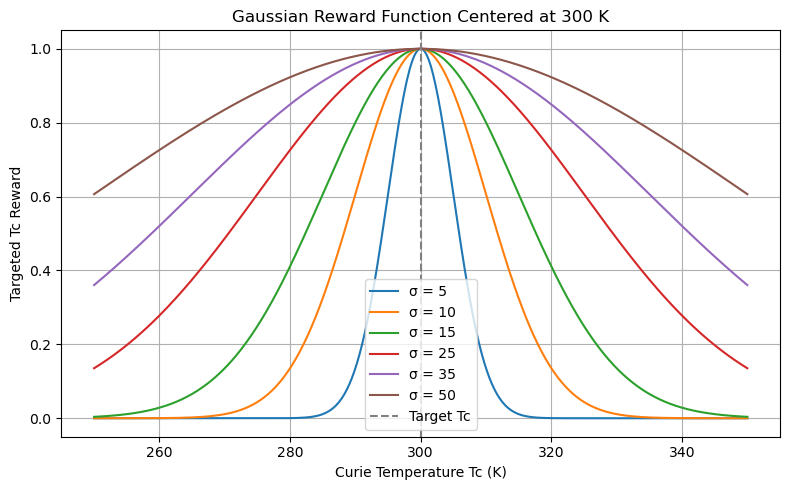

In [14]:
def plot_tc_reward_gaussians(target=300, sigmas=[5, 10, 15, 25, 35, 50]):
    Tc = np.linspace(250, 350, 500)

    plt.figure(figsize=(8, 5))
    for sigma in sigmas:
        reward = np.exp(-((Tc - target) ** 2) / (2 * sigma ** 2))
        plt.plot(Tc, reward, label=f"σ = {sigma}")

    plt.axvline(x=target, color="gray", linestyle="--", label="Target Tc")
    plt.xlabel("Curie Temperature Tc (K)")
    plt.ylabel("Targeted Tc Reward")
    plt.title("Gaussian Reward Function Centered at 300 K")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_tc_reward_gaussians()